<a href="https://colab.research.google.com/github/Princy02/JAVA/blob/main/online_auction_bids_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Auctions represent a dynamic marketplace, with participants engaging in real-time bidding wars to secure desired items. Traditionally, the emphasis in auction-related analytics has been on predicting the final sale price.

This focus, while undoubtedly valuable, overlooks a wealth of information contained in the intermediate bidding activity. Each bid, beyond its monetary value, captures a moment of strategic decision-making, a reflection of perceived value, and an indicator of market enthusiasm. Despite the abundance of models aimed at predicting sale or auction final prices, there remains a conspicuous gap in models dedicated to forecasting the granular bid-by-bid trajectory leading to that final price. This project seeks to bridge this gap.

By leveraging online auction data, we introduce a predictive algorithm that not only anticipates the final auction price based on factors like the open bid, auction item, and auction length, but also provides insights into the anticipated progression of bids leading to that culmination. In doing so, we illuminate the oft-overlooked nuances of auction dynamics, offering stakeholders a richer, more detailed picture of auction behavior.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import random
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 1. Analyse Data

In [ ]:
df = pd.read_csv('auction.csv')
df.head()

,auctionid,bid,bidtime,bidder,bidderrate,openbid,price,item,auction_type
0,1638893549,175.0,2.230949,schadenfreud,0.0,99.0,177.5,Cartier wristwatch,3 day auction
1,1638893549,100.0,2.600116,chuik,0.0,99.0,177.5,Cartier wristwatch,3 day auction
2,1638893549,120.0,2.600810,kiwisstuff,2.0,99.0,177.5,Cartier wristwatch,3 day auction
3,1638893549,150.0,2.601076,kiwisstuff,2.0,99.0,177.5,Cartier wristwatch,3 day auction
4,1638893549,177.5,2.909826,eli.flint@flightsafety.co,4.0,99.0,177.5,Cartier wristwatch,3 day auction


In [ ]:
df.groupby(['item']).agg(total_count=('auctionid', 'count'))

,total_count
item,
Cartier wristwatch,1953
Palm Pilot M515 PDA,5917
Xbox game console,2811


Get the number of missing data points per column

In [ ]:
missing_values_count = df.isnull().sum()
missing_values_count

auctionid        0
bid              0
bidtime          0
bidder          16
bidderrate      11
openbid          0
price            0
item             0
auction_type     0
dtype: int64

Fill missing bidder rate with average bidder rate per item

In [ ]:
df['bidderrate'] = df.groupby('item')['bidderrate'].transform(lambda x: x.fillna(x.mean()))

Fill missing bidders with already existing bidders

In [ ]:
# Get the count of missing values
missing_count = df['bidder'].isna().sum()

# Sample random non-missing values
random_values = df['bidder'].dropna().sample(n=missing_count, replace=True).reset_index(drop=True).values

# Fill missing values
mask = df['bidder'].isna()
df.loc[mask, 'bidder'] = random_values

Check missing columns again

In [ ]:
missing_values_count = df.isnull().sum()
missing_values_count

auctionid       0
bid             0
bidtime         0
bidder          0
bidderrate      0
openbid         0
price           0
item            0
auction_type    0
dtype: int64

In [ ]:
df.head(20)

,auctionid,bid,bidtime,bidder,bidderrate,openbid,price,item,auction_type
0,1638893549,175.00,2.230949,schadenfreud,0.0,99.0,177.5,Cartier wristwatch,3 day auction
1,1638893549,100.00,2.600116,chuik,0.0,99.0,177.5,Cartier wristwatch,3 day auction
2,1638893549,120.00,2.600810,kiwisstuff,2.0,99.0,177.5,Cartier wristwatch,3 day auction
3,1638893549,150.00,2.601076,kiwisstuff,2.0,99.0,177.5,Cartier wristwatch,3 day auction
4,1638893549,177.50,2.909826,eli.flint@flightsafety.co,4.0,99.0,177.5,Cartier wristwatch,3 day auction
5,1639453840,1.00,0.355856,bfalconb,2.0,1.0,355.0,Cartier wristwatch,3 day auction
6,1639453840,1.25,0.484757,sbord,1.0,1.0,355.0,Cartier wristwatch,3 day auction
7,1639453840,1.50,0.492639,bfalconb,2.0,1.0,355.0,Cartier wristwatch,3 day auction
8,1639453840,25.00,0.494630,sbord,1.0,1.0,355.0,Cartier wristwatch,3 day auction
9,1639453840,2.00,0.511169,bfalconb,2.0,1.0,355.0,Cartier wristwatch,3 day auction


#### Investigate correlation

Draw pairplot matrix

In [ ]:
sns.set_theme(style="ticks")

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


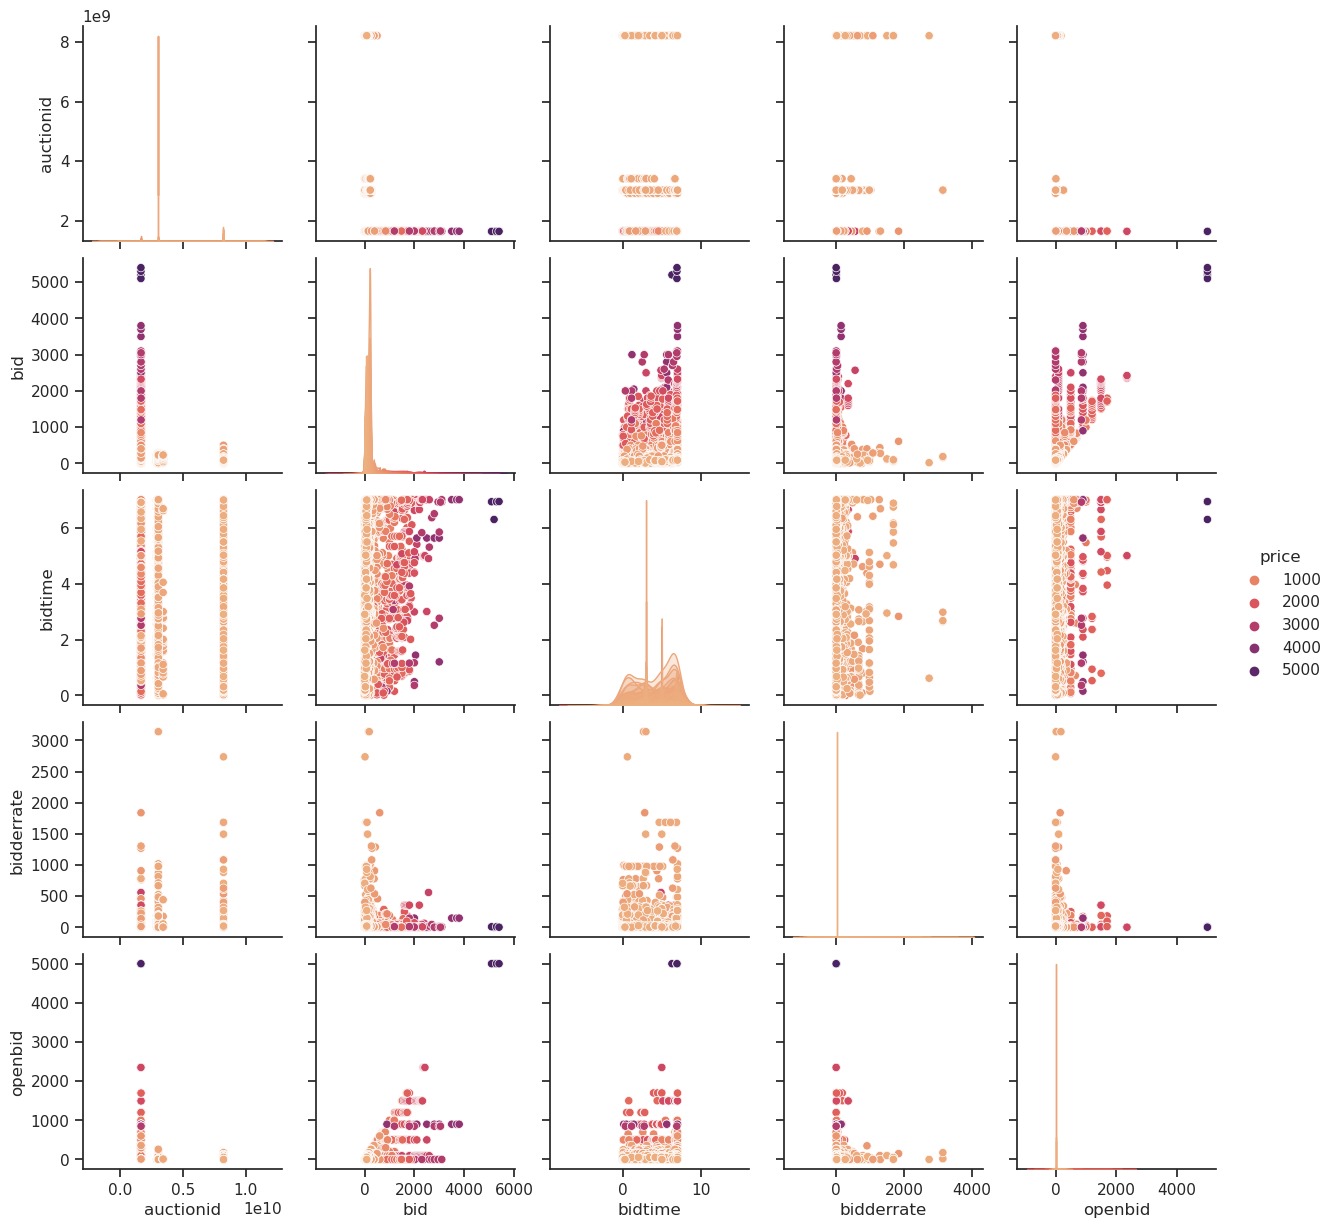

In [ ]:
sns.pairplot(df, hue="price", palette="flare")

We see some expected correlations (openbid and bid) and some unexpected (auctionid and bid), let's check Pearson's correlation matrix.
There are also quite a few outliers, those will be fixed below.

We want to encode our categorical values now to properly check correlation

In [ ]:
bidder_encoder = LabelEncoder()
df['bidder'] = bidder_encoder.fit_transform(df['bidder'])
df['bidder'] = df['bidder'].astype('category')
item_encoder = LabelEncoder()
df['item'] = item_encoder.fit_transform(df['item'])
df['item'] = df['item'].astype('category')
auction_type_encoder = LabelEncoder()
df['auction_type'] = auction_type_encoder.fit_transform(df['auction_type'])
df['auction_type'] = df['auction_type'].astype('category')
auction_id_encoder = LabelEncoder()
df['auctionid'] = auction_id_encoder.fit_transform(df['auctionid'])
df['auctionid'] = df['auctionid'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10681 entries, 0 to 10680
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   auctionid     10681 non-null  category
 1   bid           10681 non-null  float64 
 2   bidtime       10681 non-null  float64 
 3   bidder        10681 non-null  category
 4   bidderrate    10681 non-null  float64 
 5   openbid       10681 non-null  float64 
 6   price         10681 non-null  float64 
 7   item          10681 non-null  category
 8   auction_type  10681 non-null  category
dtypes: category(4), float64(5)
memory usage: 656.8 KB


/tmp/ipykernel_20/2426247509.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap=sns.diverging_palette(220, 50, as_cmap=True));


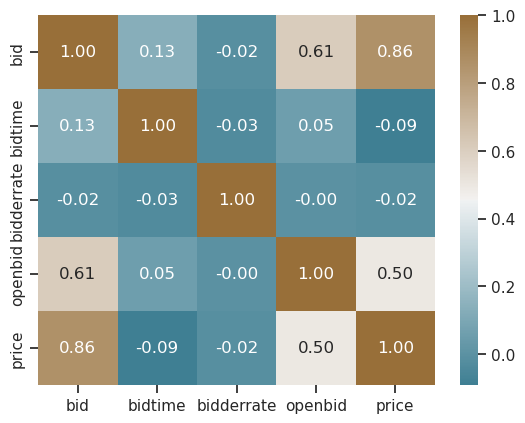

In [ ]:
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap=sns.diverging_palette(220, 50, as_cmap=True));

Here we see auctionid again correlating with bid, openbid, price, item. This column should not represent meaningful data and needs to be fixed.
Lets shuffle auctionid to remove the correlation.

In [ ]:
from numpy.random import default_rng
import numpy as np

unique_auctionids = np.unique(df['auctionid'])
rng = default_rng(42)
numbers = rng.choice(len(unique_auctionids), size=len(unique_auctionids), replace=False)
u_dict = dict(zip(unique_auctionids, numbers))
df['auctionid'] = df['auctionid'].map(u_dict)

Let's check the correlation now for auctionid and price and bid

<Axes: xlabel='auctionid', ylabel='bid'>

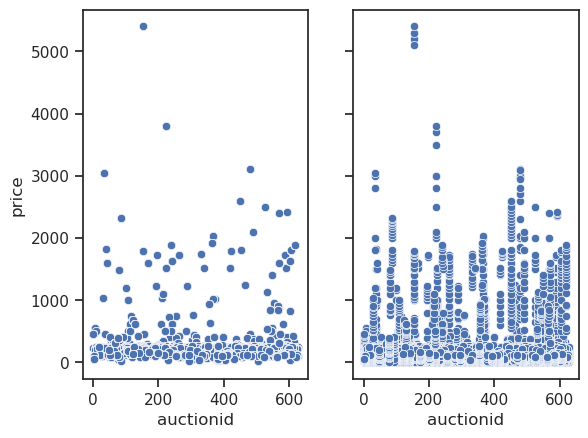

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.scatterplot(data=df, x='auctionid', y='price', ax=ax1)
sns.scatterplot(data=df, x='auctionid', y='bid', ax=ax2)

#### Fix outliers

In [ ]:
total_records = len(df)
total_records

10681

We remove price outliers by using z-score and keeping only the values that are within score of z-score of 3

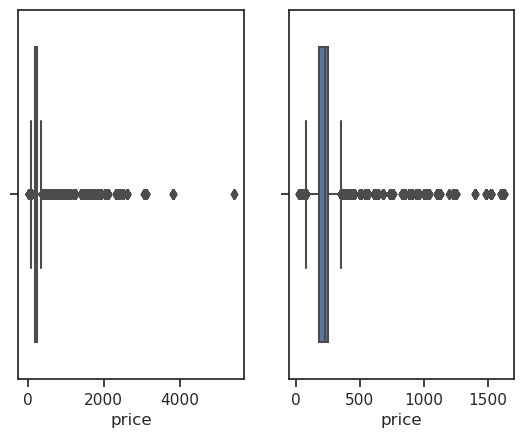

Number of outliers removed:  370


In [ ]:
from scipy import stats
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.boxplot(x=df["price"], ax=ax1)
df = df[(np.abs(stats.zscore(df['price'])) < 3)]
sns.boxplot(x=df["price"], ax=ax2)
plt.show()
print("Number of outliers removed: ", total_records - len(df))

Use the same method for openbid

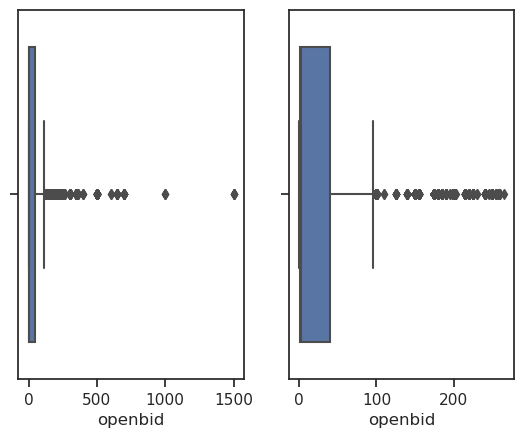

Number of outliers removed:  160


In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.boxplot(x=df["openbid"], ax=ax1)
previous_records = len(df)
df = df[(np.abs(stats.zscore(df['openbid'])) < 3)]
sns.boxplot(x=df["openbid"], ax=ax2)
plt.show()
print("Number of outliers removed: ", previous_records - len(df))

For bidderrate we clip values using IQR method and the normalisation

In [ ]:
def find_boundaries(datacolumn):
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range, upper_range

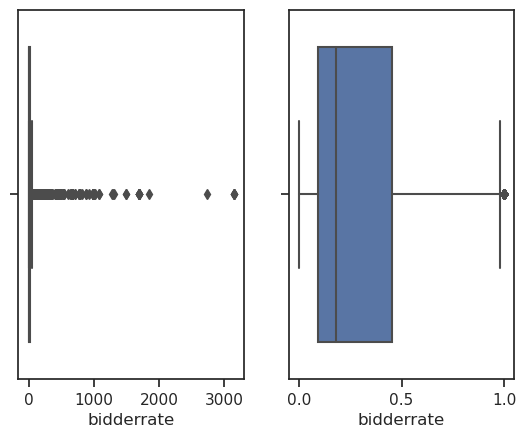

In [ ]:
from sklearn.preprocessing import MinMaxScaler
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.boxplot(x=df["bidderrate"], ax=ax1)
(_, max_value) = find_boundaries(df['bidderrate'])
df['bidderrate'] = df['bidderrate'].clip(upper=max_value)
# normalise bidder rate
scaler = MinMaxScaler()
df['bidderrate'] = scaler.fit_transform(df['bidderrate'].values.reshape(-1,1))
sns.boxplot(x=df["bidderrate"], ax=ax2)
plt.show()

We normalise bidtime as it does not have outliers

<Axes: xlabel='bidtime'>

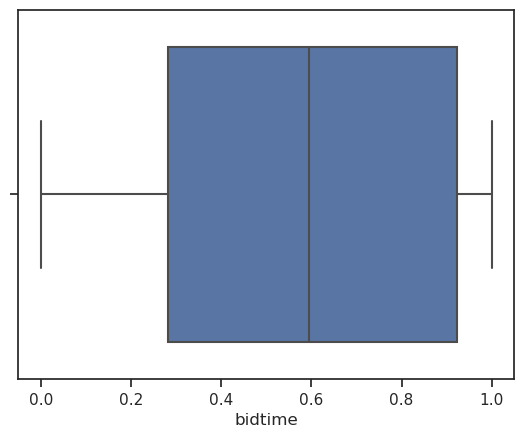

In [ ]:
scaler = MinMaxScaler()
df['bidtime'] = scaler.fit_transform(df['bidtime'].values.reshape(-1,1))
sns.boxplot(x=df["bidtime"])

Draw pairplot matrix again to check the result

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


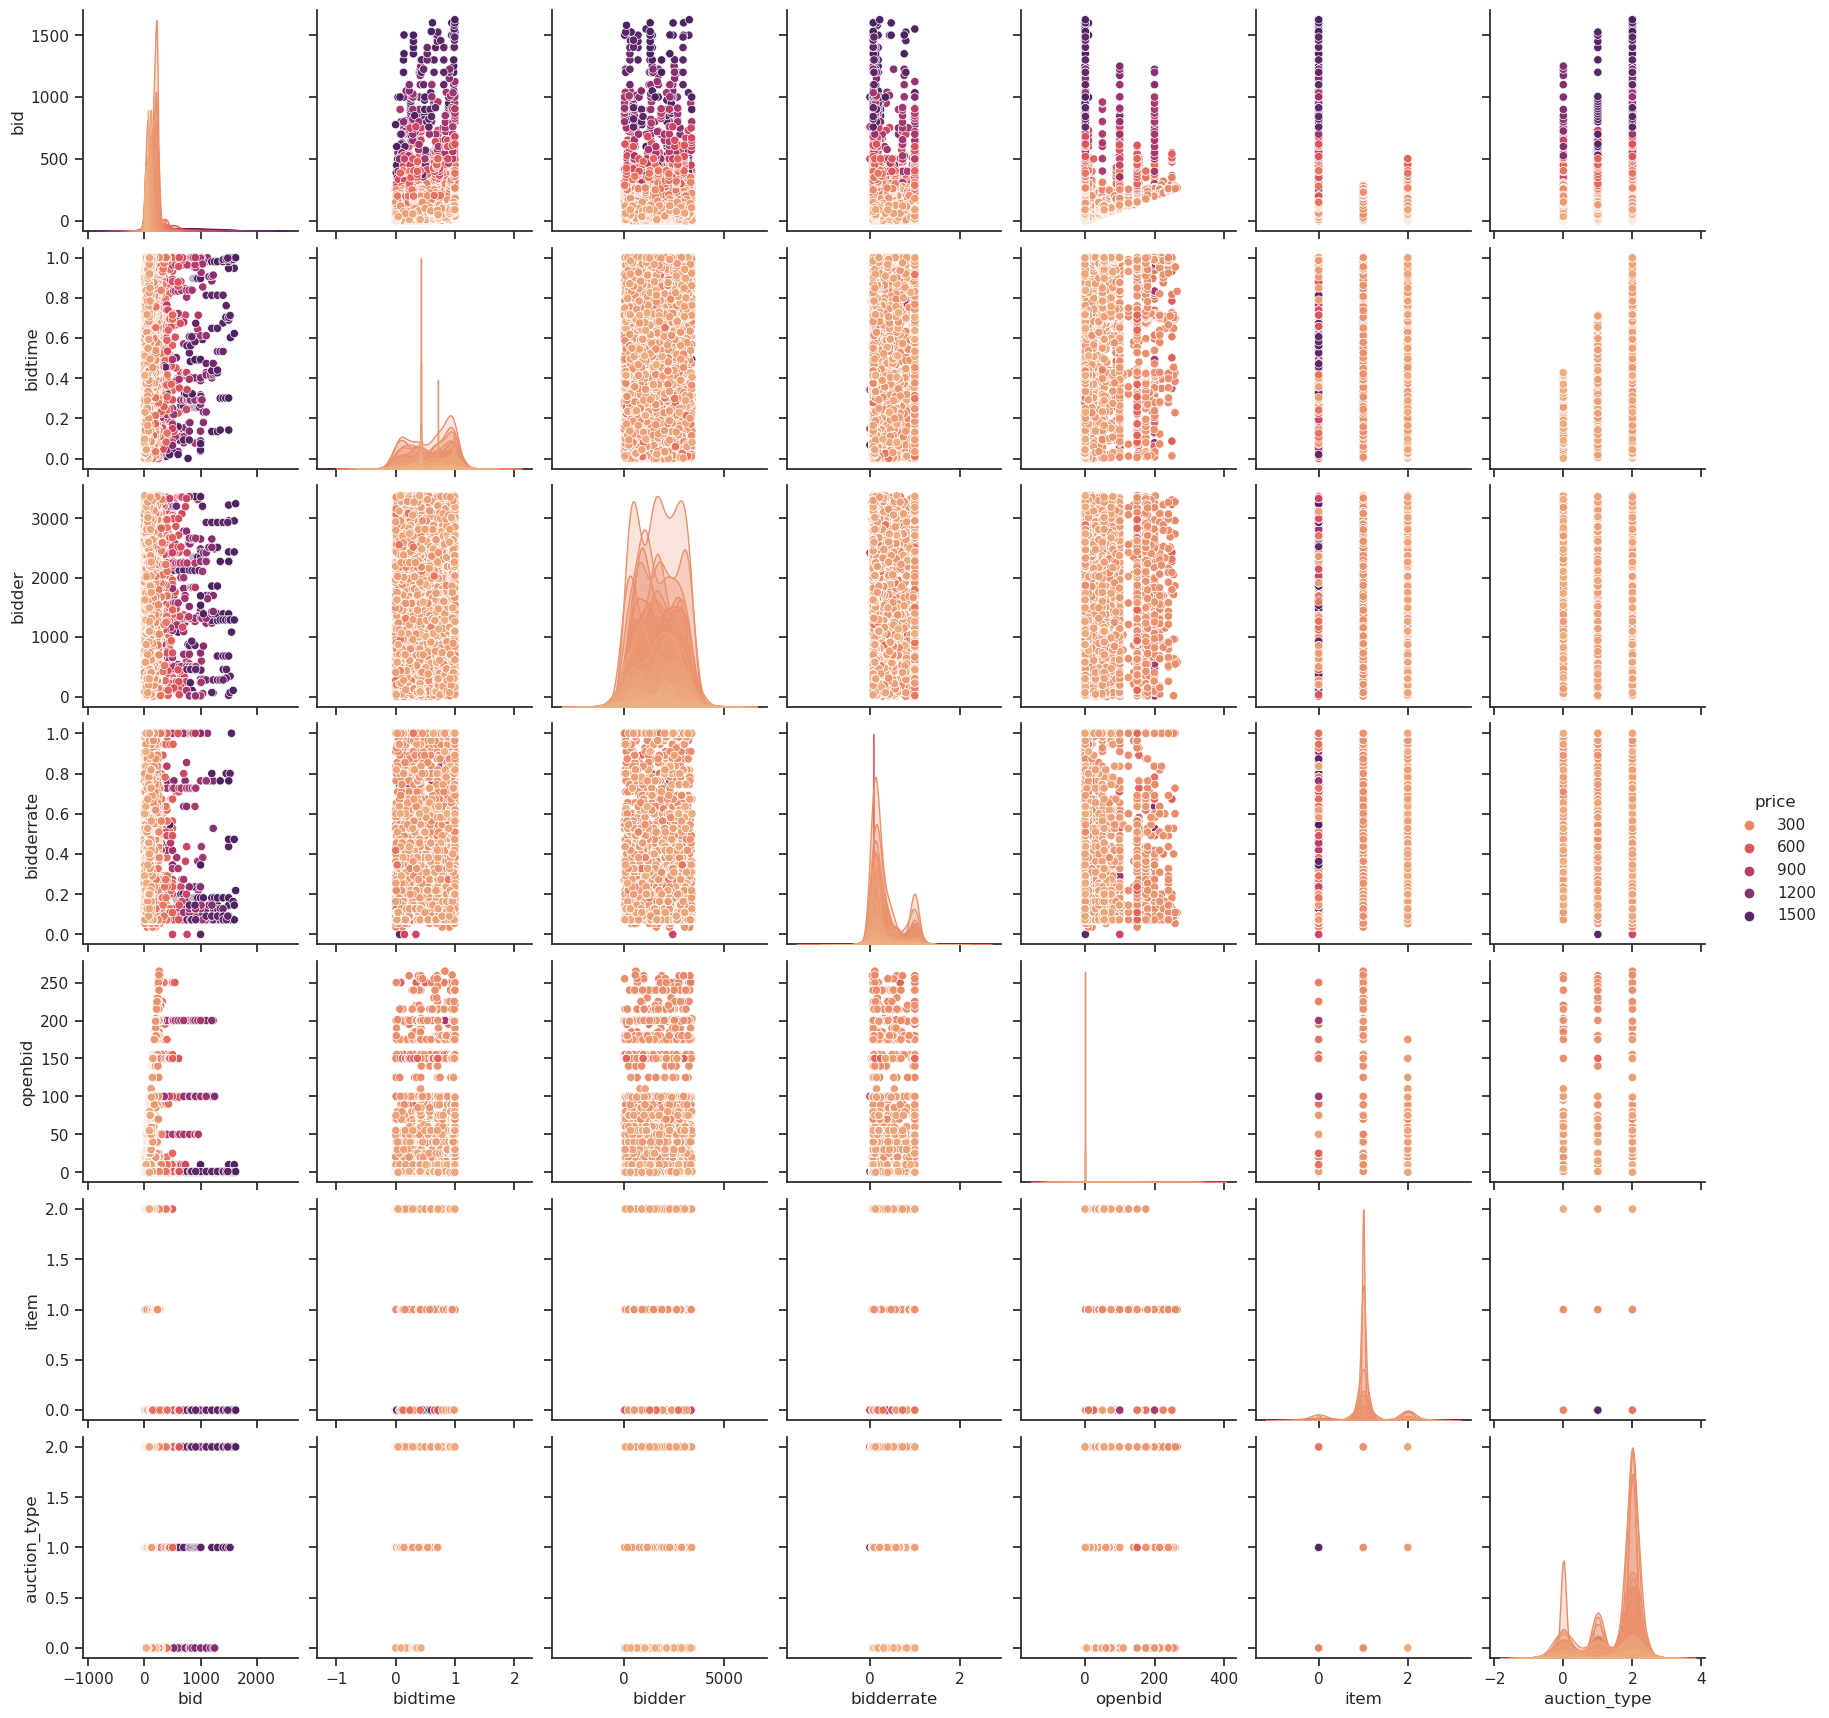

In [ ]:
p_df = df.copy()
p_df['bidder'] = p_df['bidder'].astype('int')
p_df['item'] = p_df['item'].astype('int')
p_df['auction_type'] = p_df['auction_type'].astype('int')
p_df['auctionid'] = p_df['auctionid'].astype('category')
sns.pairplot(p_df, hue="price", palette="flare")

/tmp/ipykernel_20/2426247509.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap=sns.diverging_palette(220, 50, as_cmap=True));


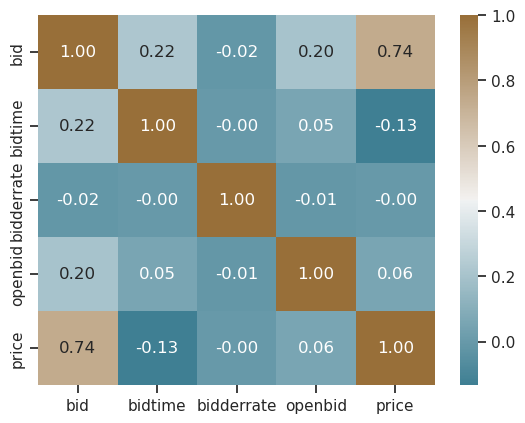

In [ ]:
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap=sns.diverging_palette(220, 50, as_cmap=True));

We have a more balanced data now, with meaningful correlations, will rename columns and save as a check-point

In [ ]:
df = df.rename(columns={'auctionid': 'auction_id', 'openbid': 'open_price', 'bid': 'bid_value', 'bidtime': 'bid_time', 'bidder': 'bidder_id', 'price': 'closing_price', 'item': 'item_id'})
df.to_csv('/kaggle/working/1_prepared_data.csv', index=False)

### 2. Estimate auction level data
We want to estimate auction price and number of bids without bids data, this will result in a very rough estimation because we will use only basic data.

In [ ]:
df = pd.read_csv('/kaggle/working/1_prepared_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10151 entries, 0 to 10150
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   auction_id     10151 non-null  int64  
 1   bid_value      10151 non-null  float64
 2   bid_time       10151 non-null  float64
 3   bidder_id      10151 non-null  int64  
 4   bidderrate     10151 non-null  float64
 5   open_price     10151 non-null  float64
 6   closing_price  10151 non-null  float64
 7   item_id        10151 non-null  int64  
 8   auction_type   10151 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 713.9 KB


##### Create base auction dataframe

In [ ]:
auction_df = df.groupby(['auction_id', 'open_price', 'closing_price', 'item_id', 'auction_type'], observed=True).agg(num_bids=('bidder_id', pd.Series.nunique)).reset_index()
auction_df = auction_df.drop(columns=['auction_id'])
auction_df.head()

,open_price,closing_price,item_id,auction_type,num_bids
0,1.00,455.0,0,2,12
1,0.01,225.0,1,0,20
2,1.00,61.0,2,2,11
3,1.00,212.5,1,0,8
4,0.01,106.0,2,1,13


Check correlation

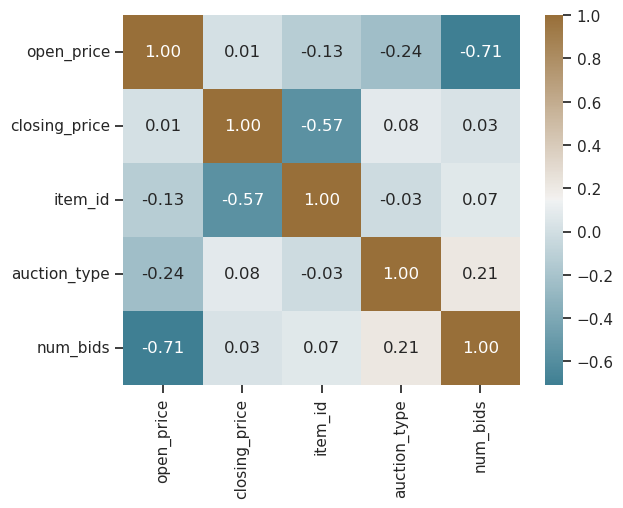

In [ ]:
sns.heatmap(auction_df.corr(), annot=True, fmt='.2f', cmap=sns.diverging_palette(220, 50, as_cmap=True));

We can see correlation pairs, all features should be important

#### Predict number of bids per auction
First we use linear regression with kfold of 5 to enstablish our baseline.
We drop closing_price because we do not expect to have it when predicting number of bids, we will use number of bids to predict an auction price after that.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score

X = auction_df.drop(columns=['closing_price', 'num_bids'], axis=1)
y = auction_df['num_bids']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr = LinearRegression()

rmse_scores = cross_val_score(lr, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")

Mean RMSE: 3.25


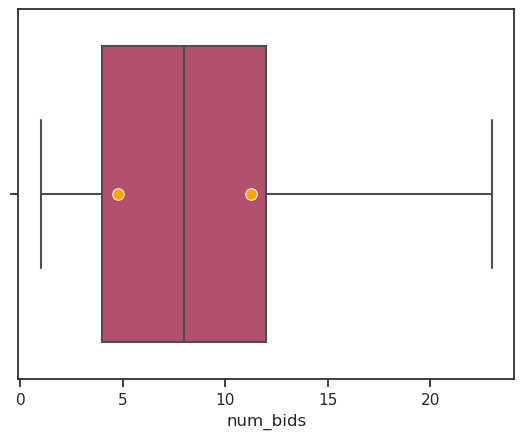

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(x=auction_df['num_bids'], palette='flare', ax=ax)
sns.scatterplot(x=[auction_df['num_bids'].median() - mean_rmse, auction_df['num_bids'].median() + mean_rmse], y=0, color='orange', s=70, ax=ax, zorder=100)
plt.show()

Linear regression estimation is not bad, but let's see if we can do better with XGBoost.

First we need to use categorical values.

In [ ]:
auction_df['item_id'] = auction_df['item_id'].astype('category')
auction_df['auction_type'] = auction_df['auction_type'].astype('category')
auction_df.dtypes

open_price        float64
closing_price     float64
item_id          category
auction_type     category
num_bids            int64
dtype: object

Try XGBoost. Will be using best parameters found with GridSearchCV.

In [ ]:
import xgboost as xgb

X = auction_df.drop(columns=['closing_price', 'num_bids'], axis=1)
y = auction_df['num_bids']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
booster = xgb.XGBRegressor(tree_method="approx", enable_categorical=True, eta=0.3, max_depth=3, n_estimators=11)

rmse_scores = cross_val_score(booster, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")

auction_num_bids_model = booster.fit(X, y)

Mean RMSE: 2.93


Using XGBoost we achieved marginal improvment, but overall RMSE score is within IQR, so we should be able to use it for rough predictions.

Let's save this model.

In [ ]:
auction_num_bids_model.save_model('/kaggle/working/2_bid_num_prediction.json')

#### Predict closing_price per auction

In [ ]:
X = auction_df.drop(columns=['closing_price'], axis=1)
y = auction_df['closing_price']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr = LinearRegression()

rmse_scores = cross_val_score(lr, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")

Mean RMSE: 168.48


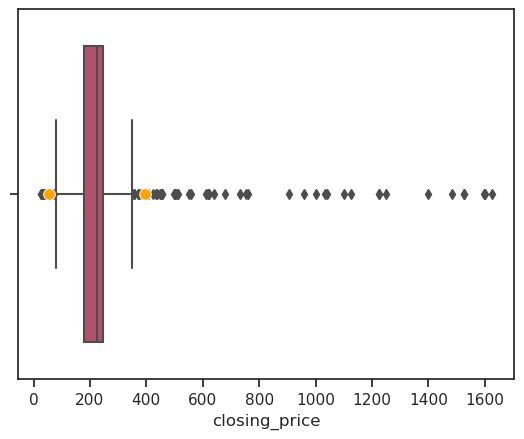

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(x=auction_df['closing_price'], palette='flare', ax=ax)
sns.scatterplot(x=[auction_df['closing_price'].median() - mean_rmse, auction_df['closing_price'].median() + mean_rmse], y=0, color='orange', s=70, ax=ax, zorder=100)
plt.show()

The result is not great and it's outside the acceptable range of standard prices. Let's try XGBoost.

In [ ]:
X = auction_df.drop('closing_price', axis=1)
y = auction_df['closing_price']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
booster = xgb.XGBRegressor(tree_method="approx", enable_categorical=True)

rmse_scores = cross_val_score(booster, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")

Mean RMSE: 188.59


Default XGBoost score is even worse. Will be using hyperparameters tuned with GridSearchCV next.

Mean RMSE: 159.02


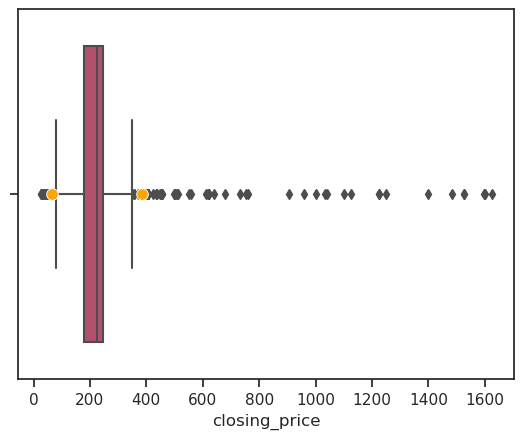

In [ ]:
X = auction_df.drop('closing_price', axis=1)
y = auction_df['closing_price']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
booster = xgb.XGBRegressor(tree_method="approx", enable_categorical=True, eta = 0.03, max_depth = 2, n_estimators = 100, subsample = 0.5)

rmse_scores = cross_val_score(booster, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")
fig, ax = plt.subplots()
sns.boxplot(x=auction_df['closing_price'], palette='flare', ax=ax)
sns.scatterplot(x=[auction_df['closing_price'].median() - mean_rmse, auction_df['closing_price'].median() + mean_rmse], y=0, color='orange', s=70, ax=ax, zorder=100)
plt.show()

Even with the optimised hyperparameters the result is not acceptable. Suspicion here is that outliers causing this price missmatch, let try reducing outliers using IQR method. However, we must make sure that we are not completely removing all records of articular item or auction type from the dataset.

In [ ]:
(min_boundary, max_boundary) = find_boundaries(auction_df['closing_price'])
reduced_auction_df = auction_df.copy()[(auction_df['closing_price'] >= min_boundary) & (auction_df['closing_price'] <= max_boundary)]
reduced_auction_df.groupby(['item_id'], observed=True)['auction_type'].value_counts()

item_id  auction_type
1        2               195
         0                95
         1                54
2        2                81
         0                32
         1                19
0        2                25
         0                 5
         1                 4
Name: auction_type, dtype: int64

Reduced auction leaves us a very small subset of item_id 0. Let's try to predict only that item closing price to check if we can achieve better performance by including this item.

Mean RMSE: 386.73


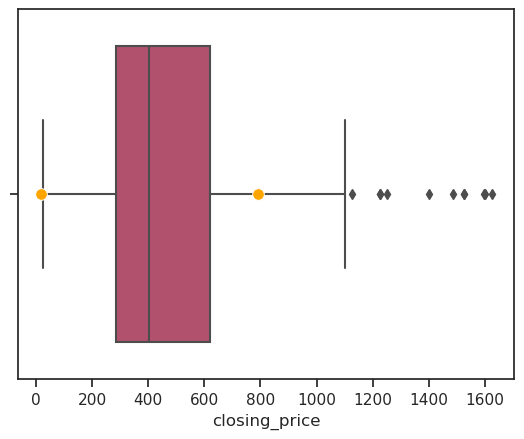

Standard deviation: 397.58


In [ ]:
zero_item_df = auction_df[auction_df.item_id == 0].copy()
X = zero_item_df.drop('closing_price', axis=1)
y = zero_item_df['closing_price']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

booster = xgb.XGBRegressor(tree_method="approx", enable_categorical=True, eta = 0.03, max_depth = 3, n_estimators = 110, subsample = 1.0)

rmse_scores = cross_val_score(booster, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")
fig, ax = plt.subplots()
sns.boxplot(x=zero_item_df['closing_price'], palette='flare', ax=ax)
sns.scatterplot(x=[zero_item_df['closing_price'].median() - mean_rmse, zero_item_df['closing_price'].median() + mean_rmse], y=0, color='orange', s=70, ax=ax, zorder=100)
plt.show()
print(f"Standard deviation: {zero_item_df['closing_price'].std():.2f}")

Performance is very poor, now let's try reduced dataset for this item only.

Mean RMSE: 69.83


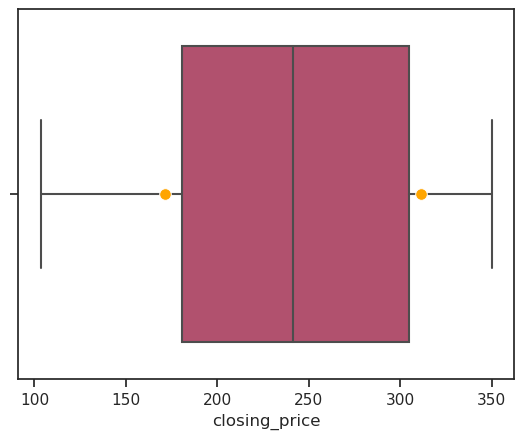

Standard deviation: 74.10


In [ ]:
reduced_zero_item_df = reduced_auction_df[reduced_auction_df.item_id == 0].copy()
X = reduced_zero_item_df.drop('closing_price', axis=1)
y = reduced_zero_item_df['closing_price']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
booster = xgb.XGBRegressor(tree_method="approx", enable_categorical=True, eta = 0.05, max_depth = 1, n_estimators = 100, reg_alpha=0.1, subsample = 0.9)

rmse_scores = cross_val_score(booster, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")
fig, ax = plt.subplots()
sns.boxplot(x=reduced_zero_item_df['closing_price'], palette='flare', ax=ax)
sns.scatterplot(x=[reduced_zero_item_df['closing_price'].median() - mean_rmse, reduced_zero_item_df['closing_price'].median() + mean_rmse], y=0, color='orange', s=70, ax=ax, zorder=100)
plt.show()
print(f"Standard deviation: {reduced_zero_item_df['closing_price'].std():.2f}")

Using reduced dataset for this item gives us similiarly poor performance. Because we have so few records and features we can assume model is underfitting in both cases and there is not much that can be done to get better performance out of it. Given that RMSE is lower than Standard deviation in the reduced dataset and for this model we want to chose more conservative price, we will proceed with reduced dataset.

Mean RMSE: 31.32


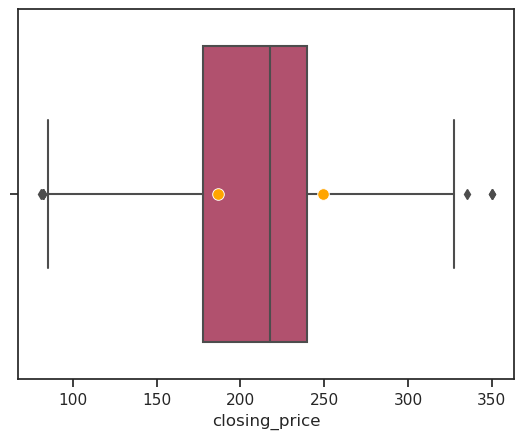

In [ ]:
(min_boundary, max_boundary) = find_boundaries(auction_df['closing_price'])
reduced_auction_df = auction_df.copy()[(auction_df['closing_price'] >= min_boundary) & (auction_df['closing_price'] <= max_boundary)]
X = reduced_auction_df.drop('closing_price', axis=1)
y = reduced_auction_df['closing_price']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
booster = xgb.XGBRegressor(tree_method="approx", enable_categorical=True, eta = 0.06, max_depth = 2, n_estimators = 110, subsample = 0.9)

rmse_scores = cross_val_score(booster, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")
fig, ax = plt.subplots()
sns.boxplot(x=reduced_auction_df['closing_price'], palette='flare', ax=ax)
sns.scatterplot(x=[reduced_auction_df['closing_price'].median() - mean_rmse, reduced_auction_df['closing_price'].median() + mean_rmse], y=0, color='orange', s=70, ax=ax, zorder=100)
plt.show()

auction_price_estimation_model = booster.fit(X, y)

Overall auction price estimation model performance is not bad given low amount of features. We will save this model.

In [ ]:
auction_price_estimation_model.save_model('/kaggle/working/2_price_estimation.json')

### 3. Bid features predictionios

Here we will build models to predict some of bids features that we will not be able to extract on a live system. Namely we expect to use open_price, item_id and auction_type values for bids generation, hence all other features should be either predicted or discarded.

In [ ]:
df = pd.read_csv('/kaggle/working/1_prepared_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10151 entries, 0 to 10150
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   auction_id     10151 non-null  int64  
 1   bid_value      10151 non-null  float64
 2   bid_time       10151 non-null  float64
 3   bidder_id      10151 non-null  int64  
 4   bidderrate     10151 non-null  float64
 5   open_price     10151 non-null  float64
 6   closing_price  10151 non-null  float64
 7   item_id        10151 non-null  int64  
 8   auction_type   10151 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 713.9 KB


For bids generation we do not care about bidder patterns, although bidder patterns might be important we want to be able to predict max bid values for each bidder assuming all of the bidders are unique.

In [ ]:
bids_df = df.groupby(['auction_id', 'bidder_id', 'item_id', 'auction_type']).agg(
    bid_value=('bid_value', 'max'),
    bid_time=('bid_time', 'max'),
    bidder_rate=('bidderrate', 'max'),
    open_price=('open_price', 'max'),
    closing_price=('closing_price', 'max')
    ).reset_index()
bids_df = bids_df.drop(columns=['bidder_id'])
bids_df.head()

,auction_id,item_id,auction_type,bid_value,bid_time,bidder_rate,open_price,closing_price
0,0,0,2,15.00,0.090697,0.327273,1.0,455.0
1,0,0,2,1.00,0.037607,1.000000,1.0,455.0
2,0,0,2,1.25,0.061688,0.072727,1.0,455.0
3,0,0,2,400.00,0.669285,0.200000,1.0,455.0
4,0,0,2,455.00,0.941665,0.254545,1.0,455.0


#### Feature engineering

We would want to have some additional features we can extract from the data. Also, we are interested in expressing relationship between bids on the same auction without using auctionid since we cannot predict it as well.

We will rank bid values in ascending order.

In [ ]:
def sort_within_group(group):
    return group.sort_values(by='bid_value', ascending=True)
bids_df = bids_df.groupby(['auction_id'], observed=True).apply(sort_within_group).reset_index(drop=True)
bids_df['rank'] = bids_df.groupby(['auction_id'])['bid_value'].rank(method='dense')
bids_df['rank'] = bids_df['rank'].astype(int)

Now we will add a number of bids per auction, so that each bid would have rank/num_bids pairs.

In [ ]:
bids_df['num_bids'] = bids_df.groupby('auction_id')['item_id'].transform('count')
bids_df['num_bids'] = bids_df['num_bids'].astype(int)

We will calculate previous bid value, on the first auction bid we will use open_price as a previous value.

In [ ]:
groups = bids_df.groupby('auction_id')
bids_df['prev_bid_value'] = groups['bid_value'].shift(1)
bids_df['prev_bid_value'] = bids_df['prev_bid_value'].fillna(bids_df['open_price'])

We also want to calculate average value of all previous bids so that when predicting on a given rank we could have more informations about auction's bids, not only previous value.

In [ ]:
out = (bids_df
       .assign(average=bids_df
               .groupby(['auction_id'])['prev_bid_value']
               .transform(lambda x: x.expanding().mean().shift(1))
               )
       )
out[['prev_bid_value', 'prev_bid_value_avg']] = out[['prev_bid_value', 'average']].ffill(axis=1)
bids_df = out.drop('average', axis=1)
bids_df.head(40)

,auction_id,item_id,auction_type,bid_value,bid_time,bidder_rate,open_price,closing_price,rank,num_bids,prev_bid_value,prev_bid_value_avg
0,0,0,2,1.00,0.037607,1.000000,1.00,455.0,1,12,1.00,1.000000
1,0,0,2,1.25,0.061688,0.072727,1.00,455.0,2,12,1.00,1.000000
2,0,0,2,15.00,0.090697,0.327273,1.00,455.0,3,12,1.25,1.000000
3,0,0,2,51.00,0.108104,0.436364,1.00,455.0,4,12,15.00,1.083333
4,0,0,2,55.00,0.212425,0.600000,1.00,455.0,5,12,51.00,4.562500
5,0,0,2,166.00,0.061892,1.000000,1.00,455.0,6,12,55.00,13.850000
6,0,0,2,295.00,0.299562,0.145455,1.00,455.0,7,12,166.00,20.708333
7,0,0,2,320.00,0.396898,0.254545,1.00,455.0,8,12,295.00,41.464286
8,0,0,2,400.00,0.669285,0.200000,1.00,455.0,9,12,320.00,73.156250
9,0,0,2,420.00,0.996491,0.127273,1.00,455.0,10,12,400.00,100.583333


Let's check correlations.

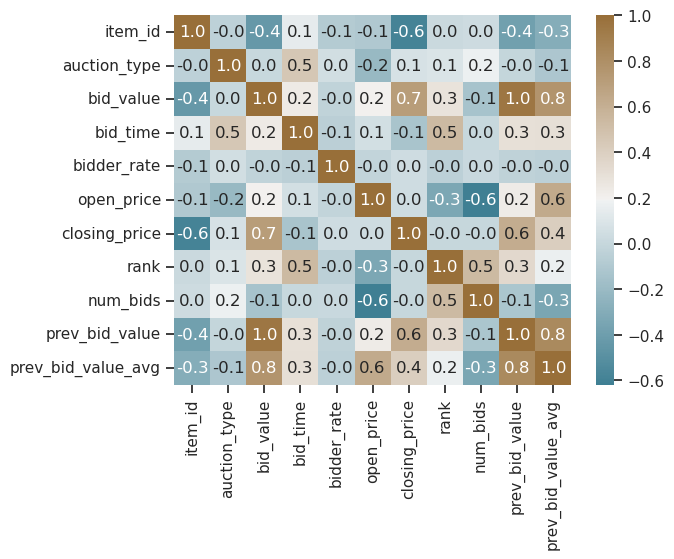

In [ ]:
sns.heatmap(bids_df.drop(columns=['auction_id']).corr(), annot=True, fmt='.1f', cmap=sns.diverging_palette(220, 50, as_cmap=True));

Let's save this data for bid value prediction later.

In [ ]:
bids_df.to_csv('/kaggle/working/3_bids.csv', index=False)

For features prediction we will not to operate without auction_id and bid_value, so we will drop these columns here.

In [ ]:
bids_df = bids_df.drop(columns=['auction_id', 'bid_value'])

Set our column types.

In [ ]:
bids_df['item_id'] = bids_df['item_id'].astype('category')
bids_df['auction_type'] = bids_df['auction_type'].astype('category')
bids_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4928 entries, 0 to 4927
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   item_id             4928 non-null   category
 1   auction_type        4928 non-null   category
 2   bid_time            4928 non-null   float64 
 3   bidder_rate         4928 non-null   float64 
 4   open_price          4928 non-null   float64 
 5   closing_price       4928 non-null   float64 
 6   rank                4928 non-null   int64   
 7   num_bids            4928 non-null   int64   
 8   prev_bid_value      4928 non-null   float64 
 9   prev_bid_value_avg  4928 non-null   float64 
dtypes: category(2), float64(6), int64(2)
memory usage: 318.0 KB


At this point we want to predict two features - bidder_rate and bid_time.
Let's start with a bidder_rate as it does not have strong correlation with other features.

In [ ]:
X = bids_df.drop(columns=['bidder_rate', 'bid_time'], axis=1)
y = bids_df['bidder_rate']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr = LinearRegression()

rmse_scores = cross_val_score(lr, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Standard deviation: {bids_df['bidder_rate'].std():.2f}")

Mean RMSE: 0.34
Standard deviation: 0.35


Performance is quit poor, let's try XGBoost.

Mean RMSE: 0.34


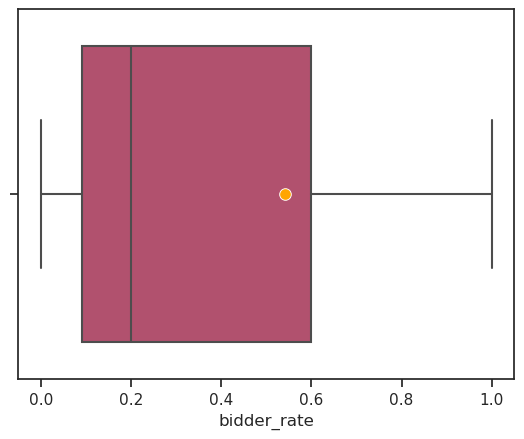

In [ ]:
X = bids_df.drop(columns=['bidder_rate', 'bid_time'], axis=1)
y = bids_df['bidder_rate']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
booster = xgb.XGBRegressor(tree_method="approx", enable_categorical=True, eta = 0.04, max_depth = 3, n_estimators = 100, subsample = 0.8)

rmse_scores = cross_val_score(booster, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")
fig, ax = plt.subplots()
sns.boxplot(x=bids_df['bidder_rate'], palette='flare', ax=ax)
sns.scatterplot(x=[bids_df['bidder_rate'].median() + mean_rmse], y=0, color='orange', s=70, ax=ax, zorder=100)
plt.show()
bid_rate_prediction_model = booster.fit(X, y)

Unfortunatelly, the model for bid rate prediction will not be accurate, however, we are more interested in bid time as bid rate has low correlation and possibly has only marginal impact on overal price.

In [ ]:
bid_rate_prediction_model.save_model('/kaggle/working/3_bid_rate_prediction.json')

We will not predict bid time.

In [ ]:
X = bids_df.drop(columns=['bid_time'], axis=1)
y = bids_df['bid_time']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr = LinearRegression()

rmse_scores = cross_val_score(lr, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Standard deviation: {bids_df['bid_time'].std():.2f}")

Mean RMSE: 0.19
Standard deviation: 0.34


Mean RMSE: 0.15


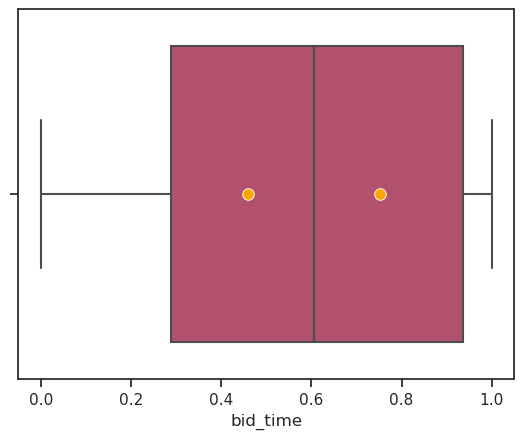

In [ ]:
X = bids_df.drop(columns=['bid_time'], axis=1)
y = bids_df['bid_time']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
booster = xgb.XGBRegressor(tree_method="approx", enable_categorical=True, eta = 0.065, max_depth = 6, n_estimators = 250, subsample = 0.7)

rmse_scores = cross_val_score(booster, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")
fig, ax = plt.subplots()
sns.boxplot(x=bids_df['bid_time'], palette='flare', ax=ax)
sns.scatterplot(x=[bids_df['bid_time'].median() - mean_rmse, bids_df['bid_time'].median() + mean_rmse], y=0, color='orange', s=70, ax=ax, zorder=100)
plt.show()
bid_time_prediction_model = booster.fit(X, y)

As expected bid time model has much better performance and is expected to have an impact on a bid value. Let's save the model.

In [ ]:
bid_time_prediction_model.save_model('/kaggle/working/3_bid_time_prediction.json')

### 4. Bid value prediction

Here we will try to predict bid value within auction. This is our main goal.

Let's prepare our dataframe.

In [ ]:
bids_df = pd.read_csv('/kaggle/working/3_bids.csv')
bids_df = bids_df.drop(columns=['auction_id'])
bids_df['item_id'] = bids_df['item_id'].astype('category')
bids_df['auction_type'] = bids_df['auction_type'].astype('category')
bids_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4928 entries, 0 to 4927
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   item_id             4928 non-null   category
 1   auction_type        4928 non-null   category
 2   bid_value           4928 non-null   float64 
 3   bid_time            4928 non-null   float64 
 4   bidder_rate         4928 non-null   float64 
 5   open_price          4928 non-null   float64 
 6   closing_price       4928 non-null   float64 
 7   rank                4928 non-null   int64   
 8   num_bids            4928 non-null   int64   
 9   prev_bid_value      4928 non-null   float64 
 10  prev_bid_value_avg  4928 non-null   float64 
dtypes: category(2), float64(7), int64(2)
memory usage: 356.5 KB


In [ ]:
X = bids_df.drop(columns=['bid_value'], axis=1)
y = bids_df['bid_value']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr = LinearRegression()

rmse_scores = cross_val_score(lr, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Standard deviation: {bids_df['bid_value'].std():.2f}")

Mean RMSE: 39.04
Standard deviation: 157.28


Mean RMSE: 38.78


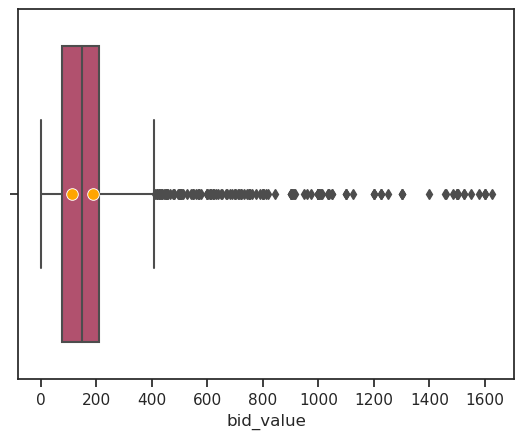

In [ ]:
X = bids_df.drop(columns=['bid_value'], axis=1)
y = bids_df['bid_value']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
booster = xgb.XGBRegressor(tree_method="approx", enable_categorical=True, eta = 0.04, max_depth = 8, n_estimators = 140, subsample = 0.4)

rmse_scores = cross_val_score(booster, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")
fig, ax = plt.subplots()
sns.boxplot(x=bids_df['bid_value'], palette='flare', ax=ax)
sns.scatterplot(x=[bids_df['bid_value'].median() - mean_rmse, bids_df['bid_value'].median() + mean_rmse], y=0, color='orange', s=70, ax=ax, zorder=100)
plt.show()
bid_value_prediction_model = booster.fit(X, y)

In this instance we are keeping outliers because we want to have a more significant range in our bid values. From price estimation we learned that these outliers are mostly related to a single item and removing them would result in a much better performance, however, as we see these prices possible we should consider having such bids included into bid value prediction model.

We will save this model.

In [ ]:
bid_value_prediction_model.save_model('/kaggle/working/4_bid_value_prediction.json')

### 5. Closing price prediction

We want to have two models for a closing_price prediction:
* bid_closing_price_estimator - Estimates closing price based on the bid data (previously we trained a model that estimates based on auction data alone)
* final_price_estimator - Estimates final closing price based on the bid data. It will be different from bid_closing_price_estimator because it will include features from the full auction data.

#### bid_closing_price_estimator

Here we will add one additional feature bid_value_delta which will specify the difference between the current bid_value and the previous_bid_value. Then we will train the model.

In [ ]:
bids_data = pd.read_csv('/kaggle/working/3_bids.csv')
bids_data = bids_data.drop(columns=['auction_id'])
bids_data['bid_value_delta'] = bids_data['bid_value'] - bids_data['prev_bid_value']

bids_data['item_id'] = bids_data['item_id'].astype('category')
bids_data['auction_type'] = bids_data['auction_type'].astype('category')
bids_data.head()

,item_id,auction_type,bid_value,bid_time,bidder_rate,open_price,closing_price,rank,num_bids,prev_bid_value,prev_bid_value_avg,bid_value_delta
0,0,2,1.00,0.037607,1.000000,1.0,455.0,1,12,1.00,1.000000,0.00
1,0,2,1.25,0.061688,0.072727,1.0,455.0,2,12,1.00,1.000000,0.25
2,0,2,15.00,0.090697,0.327273,1.0,455.0,3,12,1.25,1.000000,13.75
3,0,2,51.00,0.108104,0.436364,1.0,455.0,4,12,15.00,1.083333,36.00
4,0,2,55.00,0.212425,0.600000,1.0,455.0,5,12,51.00,4.562500,4.00


In [ ]:
X = bids_data.drop(columns=['closing_price'], axis=1)
y = bids_data['closing_price']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr = LinearRegression()

rmse_scores = cross_val_score(lr, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Standard deviation: {bids_data['closing_price'].std():.2f}")

Mean RMSE: 109.75
Standard deviation: 206.48


Mean RMSE: 74.28


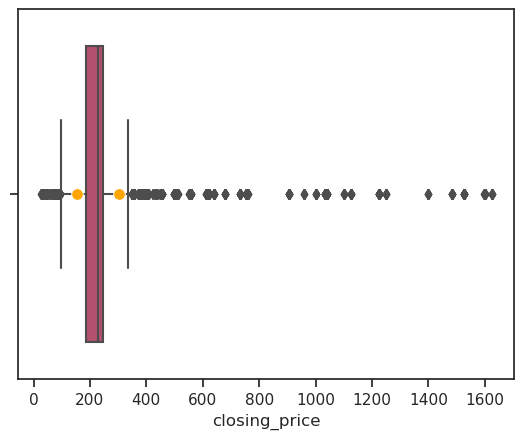

In [ ]:
X = bids_data.drop(columns=['closing_price'], axis=1)
y = bids_data['closing_price']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
booster = xgb.XGBRegressor(tree_method="approx", enable_categorical=True, eta = 0.03, max_depth = 11, n_estimators = 250, subsample = 0.5)

rmse_scores = cross_val_score(booster, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")
fig, ax = plt.subplots()
sns.boxplot(x=bids_data['closing_price'], palette='flare', ax=ax)
sns.scatterplot(x=[bids_data['closing_price'].median() - mean_rmse, bids_data['closing_price'].median() + mean_rmse], y=0, color='orange', s=70, ax=ax, zorder=100)
plt.show()
bid_closing_price_estimator = booster.fit(X, y)

We get acceptable performance from this estimator, let's save the model.

In [ ]:
bid_closing_price_estimator.save_model('/kaggle/working/5_bid_closing_price_estimator.json')

#### final_price_estimator

Now we will train final price prediction model. We expect this model to be very precise since will be adding two features that directly correlates with the final_price and are only available once all bids have been predicted.

Two new features:
* bid_value_mean - an average bid value of all bids in the auction.
* bid_value_median - a median bid valua of all bids in the auction.

In [ ]:
auction_bids = pd.read_csv('/kaggle/working/3_bids.csv')
groups = auction_bids.groupby('auction_id')
mean_bid_value = groups['bid_value'].mean()
median_bid_value = groups['bid_value'].median()

auction_bids['bid_value_mean'] = auction_bids['auction_id'].map(mean_bid_value)
auction_bids['bid_value_median'] = auction_bids['auction_id'].map(median_bid_value)
auction_bids = auction_bids.drop(columns=['auction_id'])
auction_bids['item_id'] = auction_bids['item_id'].astype('category')
auction_bids['auction_type'] = auction_bids['auction_type'].astype('category')

auction_bids.head(40)

,item_id,auction_type,bid_value,bid_time,bidder_rate,open_price,closing_price,rank,num_bids,prev_bid_value,prev_bid_value_avg,bid_value_mean,bid_value_median
0,0,2,1.00,0.037607,1.000000,1.00,455.0,1,12,1.00,1.000000,219.104167,230.50
1,0,2,1.25,0.061688,0.072727,1.00,455.0,2,12,1.00,1.000000,219.104167,230.50
2,0,2,15.00,0.090697,0.327273,1.00,455.0,3,12,1.25,1.000000,219.104167,230.50
3,0,2,51.00,0.108104,0.436364,1.00,455.0,4,12,15.00,1.083333,219.104167,230.50
4,0,2,55.00,0.212425,0.600000,1.00,455.0,5,12,51.00,4.562500,219.104167,230.50
5,0,2,166.00,0.061892,1.000000,1.00,455.0,6,12,55.00,13.850000,219.104167,230.50
6,0,2,295.00,0.299562,0.145455,1.00,455.0,7,12,166.00,20.708333,219.104167,230.50
7,0,2,320.00,0.396898,0.254545,1.00,455.0,8,12,295.00,41.464286,219.104167,230.50
8,0,2,400.00,0.669285,0.200000,1.00,455.0,9,12,320.00,73.156250,219.104167,230.50
9,0,2,420.00,0.996491,0.127273,1.00,455.0,10,12,400.00,100.583333,219.104167,230.50


Let's predict closing price

In [ ]:
X = auction_bids.drop(columns=['closing_price'], axis=1)
y = auction_bids['closing_price']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr = LinearRegression()

rmse_scores = cross_val_score(lr, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Standard deviation: {auction_bids['closing_price'].std():.2f}")

Mean RMSE: 50.30
Standard deviation: 206.48


Mean RMSE: 7.27


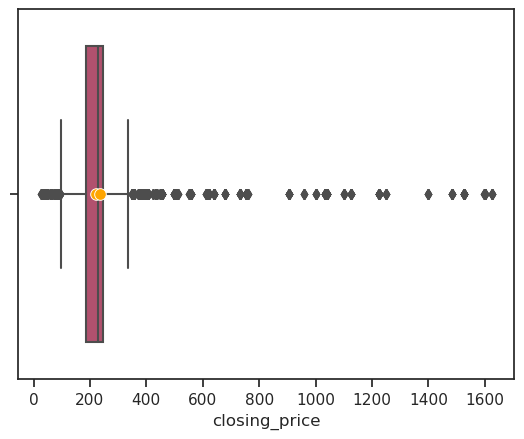

In [ ]:
X = auction_bids.drop(columns=['closing_price'], axis=1)
y = auction_bids['closing_price']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
booster = xgb.XGBRegressor(tree_method="approx", enable_categorical=True, eta = 0.03, max_depth = 11, n_estimators = 250, subsample = 0.5)

rmse_scores = cross_val_score(booster, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mean_rmse = -rmse_scores.mean()

print(f"Mean RMSE: {mean_rmse:.2f}")
fig, ax = plt.subplots()
sns.boxplot(x=auction_bids['closing_price'], palette='flare', ax=ax)
sns.scatterplot(x=[auction_bids['closing_price'].median() - mean_rmse, auction_bids['closing_price'].median() + mean_rmse], y=0, color='orange', s=70, ax=ax, zorder=100)
plt.show()
final_price_prediction_model = booster.fit(X, y)

As expected model is very accurate and provides final closing price. Let's save the model.

In [ ]:
final_price_prediction_model.save_model('/kaggle/working/5_final_price_prediction.json')

### 6. Bids generation

Having all models we need for bids generation we will implement a function that generates bids given item_id, auction_type and open_price.

First let's create label enums.

In [ ]:
from enum import Enum

class ItemId(Enum):
    CartierWristwatch = 0
    PalmPilotM515PDA = 1
    XboxGameConsole = 2

class AuctionType(Enum):
    ThreeDay = 0
    FiveDay = 1
    SevenDay = 2

In [ ]:
def generate_bids(
    item_id: ItemId,
    auction_type: AuctionType,
    open_price: float,
    bid_num_prediction_model: xgb.Booster,
    auction_price_estimation_model: xgb.Booster,
    bid_rate_prediction_model: xgb.Booster,
    bid_time_prediction_model: xgb.Booster,
    bid_value_prediction_model: xgb.Booster,
    bid_closing_price_prediction_model: xgb.Booster,
    final_auction_price_prediction_model: xgb.Booster,
    verbose=False
):

    # we first construct an auction data frame, without the bids and closing_price to predict number of bids
    auction_df = pd.DataFrame({
        'open_price': [open_price],
        'item_id': [item_id.value],
        'auction_type': [auction_type.value]
    }
    )
    bid_num_pred = bid_num_prediction_model.predict(xgb.DMatrix(auction_df))
    bid_num = int(round(bid_num_pred[0]))
    if verbose:
        print(f"Number of bids {bid_num}")
    # now we will estimate auction closing price without any bids
    auction_df['num_bids'] = [bid_num]
    auction_closing_price_pred = auction_price_estimation_model.predict(xgb.DMatrix(auction_df))
    estimated_auction_closing_price = float(round(auction_closing_price_pred[0], 2))
    if verbose:
        print(f"Estimated auction closing price {estimated_auction_closing_price}")
    # we will define a function to predict bid's based on closing price
    def predict_bid(auction_closing_price: float, rank: int, prev_bid_value: float, prev_bid_value_avg: float):
        bid_df = pd.DataFrame({
            'item_id': [item_id.value],
            'auction_type': [auction_type.value],
            'open_price': [open_price],
            'closing_price': [auction_closing_price],
            'rank': [rank],
            'num_bids': [bid_num],
            'prev_bid_value': [prev_bid_value],
            'prev_bid_value_avg': [prev_bid_value_avg]
        })
        bid_rate_pred = bid_rate_prediction_model.predict(xgb.DMatrix(bid_df))
        bid_rate = float(round(bid_rate_pred[0], 2))
        bid_df.insert(2, 'bidder_rate', [bid_rate])
        bid_time_pred = bid_time_prediction_model.predict(xgb.DMatrix(bid_df))
        bid_time = float(round(bid_time_pred[0], 2))
        bid_df.insert(2, 'bid_time', [bid_time])
        bid_value_pred = bid_value_prediction_model.predict(xgb.DMatrix(bid_df))
        bid_value = round(float(bid_value_pred[0]), 2)
        bid_df.insert(2, 'bid_value', [bid_value])
        bid_df['bid_value_delta'] = bid_df['bid_value'] - bid_df['prev_bid_value']
        return bid_df[['item_id', 'auction_type', 'bid_value', 'bid_time', 'bidder_rate', 'open_price', 'closing_price', 'rank', 'num_bids', 'prev_bid_value', 'prev_bid_value_avg', 'bid_value_delta']]
    # first bid is different, we use estimate auction price as closing price
    bid = predict_bid(auction_closing_price=estimated_auction_closing_price, rank=1, prev_bid_value=open_price, prev_bid_value_avg=open_price)
    # now we will predict the closing price with the first bid
    closing_price_estimation = bid_closing_price_pred = bid_closing_price_prediction_model.predict(xgb.DMatrix(bid.drop(columns=['closing_price'])))
    estimated_closing_price = float(round(closing_price_estimation[0], 2))
    if verbose:
        print(f"Estimated closing price {estimated_closing_price}")
    bid['closing_price'] = [estimated_closing_price]
    bids = bid.copy()
    # now we will predict the rest of the bids
    for i in range(2, bid_num + 1):
        new_bid = predict_bid(auction_closing_price=estimated_closing_price, rank=i, prev_bid_value=bids['bid_value'].iloc[-1], prev_bid_value_avg=bids['bid_value'].mean())
        # we update the closing price with each new bid
        estimated_closing_price = bid_closing_price_prediction_model.predict(xgb.DMatrix(new_bid.drop(columns=['closing_price'])))
        estimated_closing_price = float(round(closing_price_estimation[0], 2))
        bids = pd.concat(
            [
                bids,
                new_bid
            ]
        )
        bids['closing_price'] = [estimated_closing_price] * len(bids)
    # finally we will predict the final auction price using the average of the bids, and re-estimate the bids using the final auction price
    final_price_bids_df = bids.copy()
    final_price_bids_df = final_price_bids_df.drop(columns=['closing_price', 'bid_value_delta'])
    final_price_bids_df['bid_value_mean'] = final_price_bids_df['bid_value'].mean()
    final_price_bids_df['bid_value_median'] = final_price_bids_df['bid_value'].median()
    final_auction_price_pred = final_auction_price_prediction_model.predict(xgb.DMatrix(final_price_bids_df))
    final_price = round(float(final_auction_price_pred.mean()), 2)
    if verbose:
        print(f"Final auction price {final_price}")
    # predict the bids again with the final price
    bids = bids[0:0]
    for i in range(1, bid_num + 1):
        prev_bid_value = bids['bid_value'].iloc[-1] if i > 1 else open_price
        prev_bid_value_avg = bids['bid_value'].mean() if i > 1 else open_price
        new_bid = predict_bid(auction_closing_price=final_price, rank=i, prev_bid_value=prev_bid_value, prev_bid_value_avg=prev_bid_value_avg)
        bids = pd.concat(
            [
                bids,
                new_bid
            ]
        )
    if bids.iloc[-1]['bid_value'] != final_price:
        bids['closing_price'] = bids.iloc[-1]['bid_value']
    return bids


#### Test bids generation

In [ ]:
bid_num_prediction_model = xgb.Booster()
bid_num_prediction_model.load_model('/kaggle/working/2_bid_num_prediction.json')
auction_price_estimation_model = xgb.Booster()
auction_price_estimation_model.load_model('/kaggle/working/2_price_estimation.json')
bid_rate_prediction_model = xgb.Booster()
bid_rate_prediction_model.load_model('/kaggle/working/3_bid_rate_prediction.json')
bit_time_prediction_model = xgb.Booster()
bit_time_prediction_model.load_model('/kaggle/working/3_bid_time_prediction.json')
bid_value_prediction_model = xgb.Booster()
bid_value_prediction_model.load_model('/kaggle/working/4_bid_value_prediction.json')
bid_closing_price_prediction_model = xgb.Booster()
bid_closing_price_prediction_model.load_model('/kaggle/working/5_bid_closing_price_estimator.json')
final_price_prediction_model = xgb.Booster()
final_price_prediction_model.load_model('/kaggle/working/5_final_price_prediction.json')

bids = generate_bids(
    ItemId.PalmPilotM515PDA,
    AuctionType.ThreeDay,
    5.5,
    bid_num_prediction_model,
    auction_price_estimation_model,
    bid_rate_prediction_model,
    bit_time_prediction_model,
    bid_value_prediction_model,
    bid_closing_price_prediction_model,
    final_price_prediction_model,
    verbose=True
)
bids.head(20)

Number of bids 11
Estimated auction closing price 222.10000610351562
Estimated closing price 223.24000549316406
Final auction price 210.41


,item_id,auction_type,bid_value,bid_time,bidder_rate,open_price,closing_price,rank,num_bids,prev_bid_value,prev_bid_value_avg,bid_value_delta
0,1,0,16.82,0.05,0.39,5.5,210.57,1,11,5.50,5.500000,11.32
0,1,0,41.66,0.17,0.36,5.5,210.57,2,11,16.82,16.820000,24.84
0,1,0,63.20,0.15,0.35,5.5,210.57,3,11,41.66,29.240000,21.54
0,1,0,84.47,0.25,0.36,5.5,210.57,4,11,63.20,40.560000,21.27
0,1,0,113.25,0.33,0.36,5.5,210.57,5,11,84.47,51.537500,28.78
0,1,0,137.39,0.35,0.36,5.5,210.57,6,11,113.25,63.880000,24.14
0,1,0,158.46,0.35,0.35,5.5,210.57,7,11,137.39,76.131667,21.07
0,1,0,182.85,0.38,0.36,5.5,210.57,8,11,158.46,87.892857,24.39
0,1,0,195.49,0.37,0.35,5.5,210.57,9,11,182.85,99.762500,12.64
0,1,0,205.65,0.40,0.35,5.5,210.57,10,11,195.49,110.398889,10.16


Let's visualise the result

/tmp/ipykernel_20/3141767308.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x="rank", y="bid_value", palette="flare", marker="o", data=p_bids, ax=ax, color="darkred", lw=3)


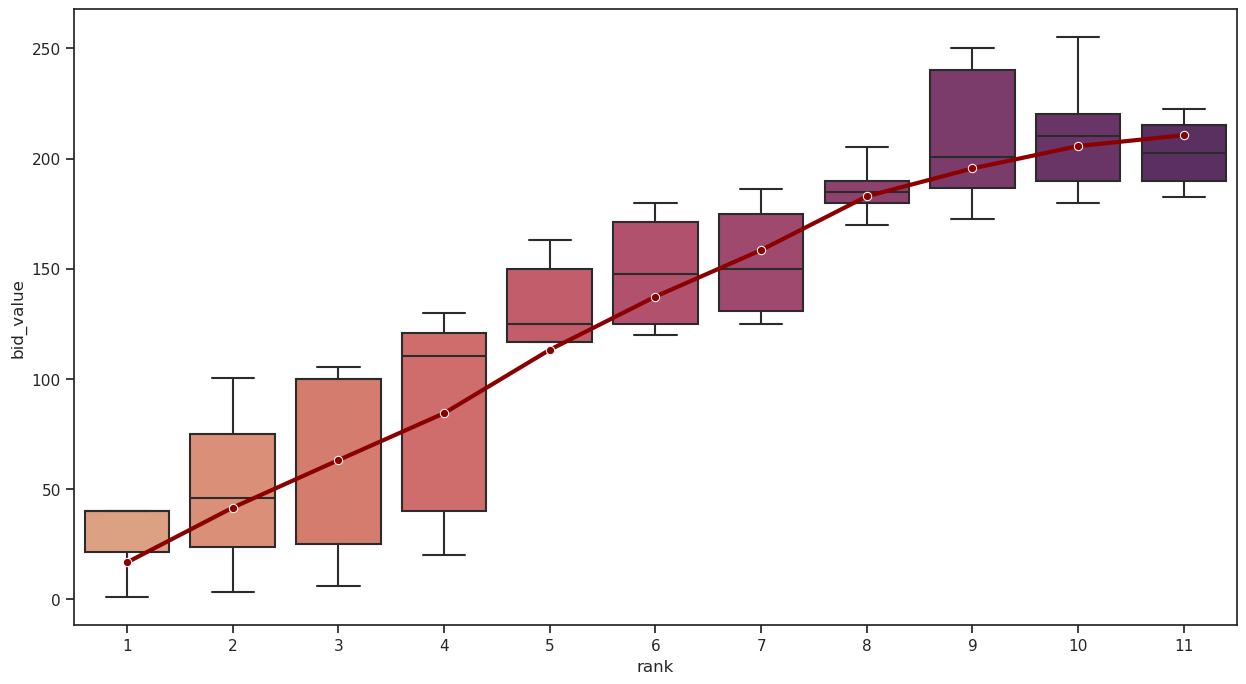

In [ ]:
p_df = pd.read_csv("/kaggle/working/3_bids.csv")
p_df = p_df[(p_df['item_id'] == ItemId.PalmPilotM515PDA.value) & (p_df['auction_type'] == AuctionType.ThreeDay.value) & (p_df['num_bids'] == len(bids))]
p_bids = bids.copy()
p_bids['rank'] = p_bids['rank'].astype(str)
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x="rank", y="bid_value",
             palette="flare",
            data=p_df, ax=ax, showfliers=False)
sns.lineplot(x="rank", y="bid_value", palette="flare", marker="o", data=p_bids, ax=ax, color="darkred", lw=3)
plt.setp(ax.lines, zorder=100)
plt.show()

Result's look good. most of the bids are in IQR range, but also different enough from mean to create dynamicsimulation. Let's summarize the result's.

First we will compute a mean open_price for each auction and each item id. Then we will predict number of bids and check deviation from standard of original data for the same number of auctions, item id and auction type.

In [ ]:
from sklearn.metrics import mean_squared_error
original_df = pd.read_csv("/kaggle/working/3_bids.csv")
validation_df = None
for item_id in [ItemId.CartierWristwatch, ItemId.PalmPilotM515PDA, ItemId.XboxGameConsole]:
    for auction_type in [AuctionType.ThreeDay, AuctionType.FiveDay, AuctionType.SevenDay]:
        open_price = original_df.loc[(original_df["item_id"] == item_id.value) & (original_df["auction_type"] == auction_type.value), "open_price"].mean()
        generated_bids = generate_bids(
            item_id,
            auction_type,
            open_price,
            bid_num_prediction_model,
            auction_price_estimation_model,
            bid_rate_prediction_model,
            bit_time_prediction_model,
            bid_value_prediction_model,
            bid_closing_price_prediction_model,
            final_price_prediction_model
        )
        num_bids = len(generated_bids)
        selected_data = original_df.loc[(original_df["item_id"] == item_id.value) & (original_df["auction_type"] == auction_type.value) & (original_df["num_bids"] == num_bids)]
        generated_bids["rmse"] = generated_bids.apply(lambda x: mean_squared_error([x["bid_value"]] * (len(selected_data.loc[selected_data["rank"] == x["rank"]])), selected_data.loc[selected_data["rank"] == x["rank"], "bid_value"], squared=False), axis=1)
        generated_bids["original_std"] = generated_bids.apply(lambda x: selected_data.loc[selected_data["rank"] == x["rank"], "bid_value"].std(), axis=1)
        if validation_df is None:
            validation_df = pd.DataFrame(columns=["item_id", "auction_type", "rank", "num_bids", "rmse", "original_std"])
        validation_df = validation_df.merge(generated_bids[["item_id", "auction_type", "rank", "num_bids", "rmse", "original_std"]], how="outer")

validation_df

,item_id,auction_type,rank,num_bids,rmse,original_std
0,0,0,1,6,61.321775,56.219985
1,0,0,2,6,55.410617,58.853689
2,0,0,3,6,349.983144,253.984908
3,0,0,4,6,559.445794,451.746610
4,0,0,5,6,549.599479,459.972825
...,...,...,...,...,...,...
68,2,2,5,9,56.256153,53.024253
69,2,2,6,9,69.043519,67.972333
70,2,2,7,9,83.390042,80.481385
71,2,2,8,9,81.942663,79.739048


<Axes: >

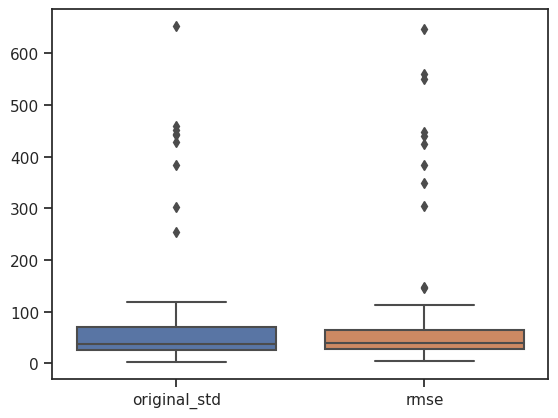

In [ ]:
sns.boxplot(validation_df[['original_std', 'rmse']])

Our bids are otuside of standard deviation of the auctions with the same number of bids, models could be improved but current solution provides reasonably good estimation of new possible bids.

## Conclusion

Through this project, we've demonstrated our model's capability to predict the number of bids and bid price in new auctions with a reasonable degree of precision. However, it's clear that there's room to hone this model further. One notable challenge is the RMSE, which occasionally veers outside the standard deviation of a bid price. This divergence can result in our forecasted final auction prices being not as spot-on as we'd like.

A deeper dive reveals that the dataset itself presents challenges. With its notable imbalance, outliers, and limited data points for certain auction configurations, it's evident that the quality and breadth of data influence our algorithm's performance. A richer dataset would likely enhance the accuracy of our predictions.

Still, our main goal was to introduce a methodology for forecasting bid trajectories and to provide insights into ongoing auctions. On this front, the project has been a constructive exercise, and we look forward to future refinements and applications.